In [1]:
%matplotlib inline
import pandas as pd
from tqdm import tqdm
import spacy
from spacy.matcher import Matcher
import numpy as np
#nlp = spacy.load('en_core_web_sm')
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
import spacy 
from tqdm import tqdm

matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42


/cellar/users/btsui/anaconda3/envs/deep_nlp_cpu/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/cellar/users/btsui/anaconda3/envs/deep_nlp_cpu/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192, got 176
  return f(*args, **kwds)
/cellar/users/btsui/anaconda3/envs/deep_nlp_cpu/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/cellar/users/btsui/anaconda3/envs/deep_nlp_cpu/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192, got 176
  return f(*args, **kwds)


In [2]:
inS_dir='/cellar/users/btsui/Data/nrnb01_nobackup/METAMAP/allSRS.pickle'

sra_dump_pickle_dir='/cellar/users/btsui/Data/SRA/DUMP/sra_dump.pickle'
spacy_model_dir='./wikipedia-pubmed-and-PMC-w2v'
nlp = spacy.load(spacy_model_dir)
srsS=pd.read_pickle(inS_dir)

technical_meta_data_df=pd.read_pickle(sra_dump_pickle_dir)

tmpDf=technical_meta_data_df.drop_duplicates('Sample')

technical_meta_data_df=tmpDf.sample(n=tmpDf.shape[0],random_state=0)

#technical_meta_data_df.head()
##take only the top ten per study to avoid study bias
n=100
subsampledSrs=technical_meta_data_df.groupby('Study').head(n=n)['Sample']

#subsampledSrs.head()

m=srsS.index.get_level_values(0).isin(subsampledSrs.values)

srsS_subS=srsS[m]

/cellar/users/btsui/anaconda3/envs/deep_nlp_cpu/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/cellar/users/btsui/anaconda3/envs/deep_nlp_cpu/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192, got 176
  return f(*args, **kwds)


In [3]:
srsS_subS.head()

SRS1024493  TITLE                             Leaf sample from Camellia oleifera
            DESCRIPTION        Leaf samples were collected from flowering wil...
            SCIENTIFIC_NAME                                    Camellia oleifera
            SUBMITTER_ID                                                    JG03
            dev_stage                                                  Flowering
dtype: object

In [4]:
attribVC=srsS_subS.index.get_level_values(1).value_counts()

In [5]:
srs_resetDf=srsS_subS.reset_index()
srs_resetDf.columns=['srs','attrib','word']

In [6]:
recurr_attrib=attribVC.index[attribVC>100]

In [8]:
subRecurDf=srs_resetDf[srs_resetDf.attrib.isin(recurr_attrib)]

In [9]:
shuffledDf=subRecurDf.sample(subRecurDf.shape[0])

In [10]:
subsetDf=shuffledDf.groupby('attrib').head(n=100)

In [11]:
inProcessDf=subsetDf

In [12]:
docs=nlp.pipe(inProcessDf['word'].tolist())

In [13]:
vectors=[doc.vector for doc in  tqdm(docs,total=inProcessDf.shape[0])]

doc_vectorDf=pd.DataFrame(vectors,index=inProcessDf.set_index(['srs','attrib','word']).index).astype(float)

100%|██████████| 288800/288800 [00:23<00:00, 12472.64it/s]


In [14]:
g=doc_vectorDf.groupby('attrib')

In [15]:
print ('total # of attributes: ',len(g))

total # of attributes:  2888


In [16]:
enetityEmbeddingDf=g.mean()

In [17]:
#some of the data didn't have any reads
validEmbeddingDf=enetityEmbeddingDf[enetityEmbeddingDf.sum(axis=1).abs()>0]

In [27]:
enetityEmbeddingDf.shape

(2888, 200)

In [18]:
def corr_df(df1,df2,metric='cosine' ):
    import scipy.spatial as sp
    M = 1 - sp.distance.cdist(df1, df2, metric)
    print (M.shape)
    return pd.DataFrame(data=M,index=df1.index,columns=df2.index)
corrDf=corr_df(validEmbeddingDf,validEmbeddingDf)

(2767, 2767)


In [69]:
corrDf.columns=list(corrDf.index)
corrDf.columns.name='attrib2'
corrDf.index.name='attrib1'
np.fill_diagonal(corrDf.as_matrix(),1)

/cellar/users/btsui/anaconda3/envs/deep_nlp_cpu/lib/python3.6/site-packages/ipykernel_launcher.py:4: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  after removing the cwd from sys.path.


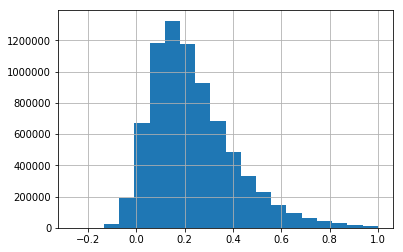

In [70]:
corrDf.unstack().dropna().hist(bins=20)

In [71]:
#attribVC.loc['growth conditions']

In [72]:
corrDf.loc[:,corrDf.columns.str.contains('scientific')].head()

attrib2,host scientific name,host_scientific_name,scientific_name
attrib1,,,
,0.221845,0.162929,0.149478
"""PUBLIC""",0.093716,0.087307,0.058855
"""geographic location (country and/or sea,region)""",0.133429,0.140504,0.093043
16S_region,0.149514,0.170309,0.041410
260/280,0.067672,0.042699,-0.001958


In [560]:
#recurr_attribs=attribVC.index[attribVC>100]
#organism','geo_loc_name','sex','tissue','genotype','disease'
cosine_threshold=0.8
#cell/tissue: cell type,  tissue, cell line
#,'tissue type'
#,'age'

['SCIENTIFIC_NAME','genotype','disease','cell type','geo_loc_name','treatment']
groupSeedToNewGroupName=pd.Series({'SCIENTIFIC_NAME':'Species',
                                  'genotype':'Genotype',
                                  'disease':'Disease state',
                                  'cell type':'Cell type/tissue',
                                  'geo_loc_name':'Geographical Location',
                                  'treatment':'Treatment and conditions'})
selectedSeedAttribs=groupSeedToNewGroupName.index
myDfL=[]
for myAttrib in selectedSeedAttribs:
    tmpS=corrDf[myAttrib].sort_values(ascending=False)#.loc['source name']#.dropna().sort_values(ascending=False)
    tmpDf=tmpS[tmpS>=cosine_threshold].to_frame().reset_index()
    tmpDf.columns=['Attributes','cosine']
    myDfL.append(tmpDf)
    #print(tmpDf[myAttrib])

In [561]:
#geo_loc_name
#attribTest='sample_name'


#inProcessDf[inProcessDf.attrib==attribTest].head(n=30)#collection_date


In [562]:
mergedDf=pd.concat(myDfL,keys=selectedSeedAttribs,axis=0)

In [563]:
mergedDf.index.names=['GroupName','I']

In [564]:
#mergedDf.loc['compound']

In [565]:
mergedDf_reset=mergedDf.reset_index()

In [566]:
mergedDf_reset[mergedDf_reset.GroupName=='disease']

,GroupName,I,Attributes,cosine
18,disease,0,disease,1.000000
19,disease,1,tumor type,0.873200
20,disease,2,diagnosis,0.856684
21,disease,3,disease state,0.851253
22,disease,4,DiseaseState,0.834955
23,disease,5,cancer type,0.824700
24,disease,6,tumor,0.823679
25,disease,7,clinical history,0.821917
26,disease,8,disease status,0.817646
27,disease,9,cell description,0.804365


In [567]:
#attribVC

In [568]:
mergedDf_reset['VC']=attribVC[mergedDf_reset.Attributes].values

In [569]:
mergedDf_reset[mergedDf_reset.GroupName	=='compound']

,GroupName,I,Attributes,cosine,VC


In [570]:
subsetDf=mergedDf_reset[mergedDf_reset['cosine']>=0.8]

subsetDf['GroupName']=groupSeedToNewGroupName[subsetDf['GroupName']].values

In [571]:
subsetDf.GroupName.value_counts()

Cell type/tissue            16
Treatment and conditions    15
Species                     11
Geographical Location       10
Disease state               10
Genotype                     7
Name: GroupName, dtype: int64

In [572]:
subsetDf.to_csv('./Results/grouping.csv')

In [573]:
#!grep -rn grouping.csv *.ipynb

In [574]:
#!cat ./Results/grouping.csv

In [559]:
subsetDf.groupby('GroupName').sum()['VC'].to_frame()

,VC
GroupName,
Cell type/tissue,417924
Disease state,34239
Genotype,122909
Geographical Location,509997
Species,1416172
Treatment and conditions,90516


In [399]:
subsetDf.groupby('GroupName').first()['VC']/subsetDf.groupby('GroupName').sum()['VC']


GroupName
SCIENTIFIC_NAME    0.802767
age                0.702257
breed              1.000000
cell line          0.750326
cell type          0.226881
dev_stage          0.623596
disease            0.632437
genotype           0.614813
geo_loc_name       0.764516
isolate            0.752301
sample_type        0.125054
sex                0.721619
strain             0.920802
treatment          0.806940
Name: VC, dtype: float64

In [400]:
mergedDf_reset[mergedDf_reset['cosine']>0.8]

,GroupName,I,Attributes,cosine,VC
0,SCIENTIFIC_NAME,0,SCIENTIFIC_NAME,1.000000,1136856
1,SCIENTIFIC_NAME,1,organism,0.983355,29037
2,SCIENTIFIC_NAME,2,Organism,0.897151,2894
3,SCIENTIFIC_NAME,3,host scientific name,0.863731,9909
4,SCIENTIFIC_NAME,4,Species,0.851593,578
5,SCIENTIFIC_NAME,5,host,0.837771,205511
6,SCIENTIFIC_NAME,6,specific host,0.830889,11114
7,SCIENTIFIC_NAME,7,host_scientific_name,0.826836,4297
8,SCIENTIFIC_NAME,8,host organism,0.825852,372
9,SCIENTIFIC_NAME,9,nat-host,0.819286,1516


In [401]:
recurr_attribs=attribVC.index[attribVC>100]
cosinDf=corrDf[attribTest].sort_values(ascending=False).head(n=20).to_frame()#.loc['source name']#.dropna().sort_values(ascending=False)
cosinDf['n']=attribVC.loc[:]

In [402]:
cosinDf

,sample_name,n
attrib1,,
sample_name,1.000000,30517
sample_title,0.802975,22382
SUBMITTER_ID,0.787158,747357
source_material_id,0.783863,23510
label,0.781657,19838
host_subject_id,0.773550,36272
sample_ID,0.773218,2240
sample id,0.772147,1095
code,0.763271,721


In [403]:
#print ("\n".join(attribVC.head(n=100).to_frame().index))

In [404]:
"""
https://metamap.nlm.nih.gov/Docs/SemGroups_2013.txt

Activities & Behaviors
Anatomy
Chemicals & Drugs
Concepts & Ideas
Devices
Disorders
Genes & Molecular Sequences
Living Beings
Geographic Areas
Objects
Organizations
Physiology
Procedures

ACTI|Activities & Behaviors|T052|Activity
ACTI|Activities & Behaviors|T053|Behavior
ACTI|Activities & Behaviors|T056|Daily or Recreational Activity
ACTI|Activities & Behaviors|T051|Event
ACTI|Activities & Behaviors|T064|Governmental or Regulatory Activity
ACTI|Activities & Behaviors|T055|Individual Behavior
ACTI|Activities & Behaviors|T066|Machine Activity
ACTI|Activities & Behaviors|T057|Occupational Activity
ACTI|Activities & Behaviors|T054|Social Behavior
ANAT|Anatomy|T017|Anatomical Structure
ANAT|Anatomy|T029|Body Location or Region
ANAT|Anatomy|T023|Body Part, Organ, or Organ Component
ANAT|Anatomy|T030|Body Space or Junction
ANAT|Anatomy|T031|Body Substance
ANAT|Anatomy|T022|Body System
ANAT|Anatomy|T025|Cell
ANAT|Anatomy|T026|Cell Component
ANAT|Anatomy|T018|Embryonic Structure
ANAT|Anatomy|T021|Fully Formed Anatomical Structure
ANAT|Anatomy|T024|Tissue
CHEM|Chemicals & Drugs|T116|Amino Acid, Peptide, or Protein
CHEM|Chemicals & Drugs|T195|Antibiotic
CHEM|Chemicals & Drugs|T123|Biologically Active Substance
CHEM|Chemicals & Drugs|T122|Biomedical or Dental Material
CHEM|Chemicals & Drugs|T118|Carbohydrate
CHEM|Chemicals & Drugs|T103|Chemical
CHEM|Chemicals & Drugs|T120|Chemical Viewed Functionally
CHEM|Chemicals & Drugs|T104|Chemical Viewed Structurally
CHEM|Chemicals & Drugs|T200|Clinical Drug
CHEM|Chemicals & Drugs|T111|Eicosanoid
CHEM|Chemicals & Drugs|T196|Element, Ion, or Isotope
CHEM|Chemicals & Drugs|T126|Enzyme
CHEM|Chemicals & Drugs|T131|Hazardous or Poisonous Substance
CHEM|Chemicals & Drugs|T125|Hormone
CHEM|Chemicals & Drugs|T129|Immunologic Factor
CHEM|Chemicals & Drugs|T130|Indicator, Reagent, or Diagnostic Aid
CHEM|Chemicals & Drugs|T197|Inorganic Chemical
CHEM|Chemicals & Drugs|T119|Lipid
CHEM|Chemicals & Drugs|T124|Neuroreactive Substance or Biogenic Amine
CHEM|Chemicals & Drugs|T114|Nucleic Acid, Nucleoside, or Nucleotide
CHEM|Chemicals & Drugs|T109|Organic Chemical
CHEM|Chemicals & Drugs|T115|Organophosphorus Compound
CHEM|Chemicals & Drugs|T121|Pharmacologic Substance
CHEM|Chemicals & Drugs|T192|Receptor
CHEM|Chemicals & Drugs|T110|Steroid
CHEM|Chemicals & Drugs|T127|Vitamin
CONC|Concepts & Ideas|T185|Classification
CONC|Concepts & Ideas|T077|Conceptual Entity
CONC|Concepts & Ideas|T169|Functional Concept
CONC|Concepts & Ideas|T102|Group Attribute
CONC|Concepts & Ideas|T078|Idea or Concept
CONC|Concepts & Ideas|T170|Intellectual Product
CONC|Concepts & Ideas|T171|Language
CONC|Concepts & Ideas|T080|Qualitative Concept
CONC|Concepts & Ideas|T081|Quantitative Concept
CONC|Concepts & Ideas|T089|Regulation or Law
CONC|Concepts & Ideas|T082|Spatial Concept
CONC|Concepts & Ideas|T079|Temporal Concept
DEVI|Devices|T203|Drug Delivery Device
DEVI|Devices|T074|Medical Device
DEVI|Devices|T075|Research Device
DISO|Disorders|T020|Acquired Abnormality
DISO|Disorders|T190|Anatomical Abnormality
DISO|Disorders|T049|Cell or Molecular Dysfunction
DISO|Disorders|T019|Congenital Abnormality
DISO|Disorders|T047|Disease or Syndrome
DISO|Disorders|T050|Experimental Model of Disease
DISO|Disorders|T033|Finding
DISO|Disorders|T037|Injury or Poisoning
DISO|Disorders|T048|Mental or Behavioral Dysfunction
DISO|Disorders|T191|Neoplastic Process
DISO|Disorders|T046|Pathologic Function
DISO|Disorders|T184|Sign or Symptom
GENE|Genes & Molecular Sequences|T087|Amino Acid Sequence
GENE|Genes & Molecular Sequences|T088|Carbohydrate Sequence
GENE|Genes & Molecular Sequences|T028|Gene or Genome
GENE|Genes & Molecular Sequences|T085|Molecular Sequence
GENE|Genes & Molecular Sequences|T086|Nucleotide Sequence
GEOG|Geographic Areas|T083|Geographic Area
LIVB|Living Beings|T100|Age Group
LIVB|Living Beings|T011|Amphibian
LIVB|Living Beings|T008|Animal
LIVB|Living Beings|T194|Archaeon
LIVB|Living Beings|T007|Bacterium
LIVB|Living Beings|T012|Bird
LIVB|Living Beings|T204|Eukaryote
LIVB|Living Beings|T099|Family Group
LIVB|Living Beings|T013|Fish
LIVB|Living Beings|T004|Fungus
LIVB|Living Beings|T096|Group
LIVB|Living Beings|T016|Human
LIVB|Living Beings|T015|Mammal
LIVB|Living Beings|T001|Organism
LIVB|Living Beings|T101|Patient or Disabled Group
LIVB|Living Beings|T002|Plant
LIVB|Living Beings|T098|Population Group
LIVB|Living Beings|T097|Professional or Occupational Group
LIVB|Living Beings|T014|Reptile
LIVB|Living Beings|T010|Vertebrate
LIVB|Living Beings|T005|Virus
OBJC|Objects|T071|Entity
OBJC|Objects|T168|Food
OBJC|Objects|T073|Manufactured Object
OBJC|Objects|T072|Physical Object
OBJC|Objects|T167|Substance
OCCU|Occupations|T091|Biomedical Occupation or Discipline
OCCU|Occupations|T090|Occupation or Discipline
ORGA|Organizations|T093|Health Care Related Organization
ORGA|Organizations|T092|Organization
ORGA|Organizations|T094|Professional Society
ORGA|Organizations|T095|Self-help or Relief Organization
PHEN|Phenomena|T038|Biologic Function
PHEN|Phenomena|T069|Environmental Effect of Humans
PHEN|Phenomena|T068|Human-caused Phenomenon or Process
PHEN|Phenomena|T034|Laboratory or Test Result
PHEN|Phenomena|T070|Natural Phenomenon or Process
PHEN|Phenomena|T067|Phenomenon or Process
PHYS|Physiology|T043|Cell Function
PHYS|Physiology|T201|Clinical Attribute
PHYS|Physiology|T045|Genetic Function
PHYS|Physiology|T041|Mental Process
PHYS|Physiology|T044|Molecular Function
PHYS|Physiology|T032|Organism Attribute
PHYS|Physiology|T040|Organism Function
PHYS|Physiology|T042|Organ or Tissue Function
PHYS|Physiology|T039|Physiologic Function
PROC|Procedures|T060|Diagnostic Procedure
PROC|Procedures|T065|Educational Activity
PROC|Procedures|T058|Health Care Activity
PROC|Procedures|T059|Laboratory Procedure
PROC|Procedures|T063|Molecular Biology Research Technique
PROC|Procedures|T062|Research Activity
PROC|Procedures|T061|Therapeutic or Preventive Procedure
"""

'\nhttps://metamap.nlm.nih.gov/Docs/SemGroups_2013.txt\n\nActivities & Behaviors\nAnatomy\nChemicals & Drugs\nConcepts & Ideas\nDevices\nDisorders\nGenes & Molecular Sequences\nLiving Beings\nGeographic Areas\nObjects\nOrganizations\nPhysiology\nProcedures\n\nACTI|Activities & Behaviors|T052|Activity\nACTI|Activities & Behaviors|T053|Behavior\nACTI|Activities & Behaviors|T056|Daily or Recreational Activity\nACTI|Activities & Behaviors|T051|Event\nACTI|Activities & Behaviors|T064|Governmental or Regulatory Activity\nACTI|Activities & Behaviors|T055|Individual Behavior\nACTI|Activities & Behaviors|T066|Machine Activity\nACTI|Activities & Behaviors|T057|Occupational Activity\nACTI|Activities & Behaviors|T054|Social Behavior\nANAT|Anatomy|T017|Anatomical Structure\nANAT|Anatomy|T029|Body Location or Region\nANAT|Anatomy|T023|Body Part, Organ, or Organ Component\nANAT|Anatomy|T030|Body Space or Junction\nANAT|Anatomy|T031|Body Substance\nANAT|Anatomy|T022|Body System\nANAT|Anatomy|T025|Cell

In [363]:
m=srsS_subS.str.contains('fac',case=False)

In [364]:
VC=m.astype(int).groupby(level=1).sum()

In [369]:
srsS_subS[srsS_subS.index.get_level_values(1)=='isolation_source'].value_counts()

missing                                                                                                15801
not applicable                                                                                         11323
soil                                                                                                    4472
feces                                                                                                   3779
not collected                                                                                           2625
stool                                                                                                   2572
Blood                                                                                                   1911
sputum                                                                                                  1783
Human                                                                                                   1754
water              

In [370]:
VC.sort_values().tail(n=100)

Isolation Site                    23
separation method                 23
study disease                     24
facs sorting                      24
anonymized name                   24
selection method                  25
cell_type                         26
store_cond                        26
body_site                         27
time point                        28
birth_location                    28
condition for cell growth         28
molecular subtype                 29
sample material processing        30
Title                             30
method                            30
biological_replicate              31
samp_collect_device               33
submitter handle                  34
genotype/background               34
biospecimen repository            34
purification                      35
env biome                         36
treatment protocol                38
sample type                       39
antibody target description       40
source                            40
g